# Dealing with Outliers

If a listing has an absurdly high price that isn't reflective of what people will actually pay, or just isn't that relevant for a typical person who wants to list their place, that isn't good for the usefulness of our model. Therefore, I'll take a look at places that have extremely high prices and see if it makes sense to remove them.

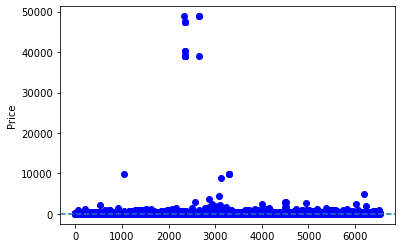

In [45]:
plt.plot(listings['price'], 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel("Price")
plt.show()

Yeah, some of these prices look like they might be absurd.

In [46]:
listings['price'].sort_values(ascending=False).head(30)

2648    48864.0
2647    48864.0
2341    48864.0
2360    47484.0
2361    47484.0
2359    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2350    39132.0
2355    39132.0
2351    39132.0
2356    39132.0
2353    39132.0
2650    39132.0
2354    39132.0
2352    39132.0
2358    39132.0
2357    39132.0
3288     9999.0
1049     9999.0
3287     9999.0
3289     9999.0
3120     9000.0
6196     5000.0
3072     4500.0
2866     3690.0
4522     3070.0
4498     3042.0
2570     3000.0
Name: price, dtype: float64

In [47]:
# Find the URL of one of the most expensive places
listings.loc[2648, 'listing_url']

'https://www.airbnb.com/rooms/30718928'

What is going on here? Following the link above, this is clearly a luxury place, but it's just a studio! On top of that, it's currently listed at USD 1,653 per night (as of December 3, 2021), not USD 48,864 per night as above. Let's take a closer look at `calendar` to see what happened:

In [48]:
listing_id = listings.loc[2648, 'id']

In [49]:
calendar.loc[calendar['listing_id']==listing_id, ['date', 'price', 'adjusted_price']]

,date,price,adjusted_price
1020296,2021-10-18,8144.0,48864.0
1020297,2021-10-19,8144.0,48864.0
1020298,2021-10-20,8144.0,48864.0
1020299,2021-10-21,8144.0,48864.0
1020300,2021-10-22,8144.0,48864.0
...,...,...,...
1023099,2022-10-13,263.0,1578.0
1023100,2022-10-14,307.0,1842.0
1023101,2022-10-15,307.0,1842.0
1023102,2022-10-16,263.0,1578.0


OK, it appears that the adjusted price was very high in mid-October, and that's what was pulled into the `price` field in `listings`. My understanding is that Airbnb allows hosts to turn on a setting that automatically adjusts the price according to demand (using some model developed by Airbnb), so likely demand was extremely high at nearby properties at that time. In any case, it would make sense for me to exclude this property and related ones from my data; I note that each of the properties over USD 10,000 are in the "Ginosi 747 Apartel", as can be easily verified by clicking on those URLs. Further, one of the next most expensive listings, at USD 9,999, is a 12-bedroom mansion.

Now I'll delete these outliers (those listings with prices above USD 10,000 per night). It makes sense to do this across all the data (not just for the training data), since I'm not interested in making predictions for places where the price would be that high (totally out of whack with what almost everyone would pay - prices that would actually banned by law for similar hotel accommodations), and I'd like to use all the data to create my final model.

In [45]:
to_drop = y[y > 10000].index

In [46]:
# Drop the necessary rows
X.drop(to_drop, inplace=True)
y.drop(to_drop, inplace=True)
# Drop the rows from the original dataframe as well (since I'll use this dataframe
# again shortly)
listings.drop(to_drop, inplace=True)

In [47]:
# Do the train-test splits again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

# Features based on words in name and description

In [32]:
X_no_words = X.copy()

Following links to some of the most expensive places, I see words like "mansion" and spacious" in the description. This gives me an idea: instead of neglecting the descriptions altogether, I should make dummy variables for a few words I expect to be highly correlated with price. (I didn't think of this feature at first, but upon adding it I got an improvement in $R^2$ of about 0.13 for the best linear models).

In [33]:
listings.loc[listings['price'] > 5000, 'listing_url']

1049    https://www.airbnb.com/rooms/15287352
2341    https://www.airbnb.com/rooms/28115625
2345    https://www.airbnb.com/rooms/28167328
2346    https://www.airbnb.com/rooms/28169607
2350    https://www.airbnb.com/rooms/28236738
2351    https://www.airbnb.com/rooms/28236779
2352    https://www.airbnb.com/rooms/28236802
2353    https://www.airbnb.com/rooms/28236839
2354    https://www.airbnb.com/rooms/28236865
2355    https://www.airbnb.com/rooms/28236884
2356    https://www.airbnb.com/rooms/28236949
2357    https://www.airbnb.com/rooms/28236962
2358    https://www.airbnb.com/rooms/28237130
2359    https://www.airbnb.com/rooms/28238620
2360    https://www.airbnb.com/rooms/28238637
2361    https://www.airbnb.com/rooms/28238649
2362    https://www.airbnb.com/rooms/28238665
2647    https://www.airbnb.com/rooms/30718918
2648    https://www.airbnb.com/rooms/30718928
2650    https://www.airbnb.com/rooms/30719093
3120    https://www.airbnb.com/rooms/35421741
3287    https://www.airbnb.com/roo

First I'll add the `name` and `description` fields as columns of X.

In [34]:
X['name'] = listings['name']

In [35]:
X['description'] = listings['description']

Now I'll make functions to find the number of times a word occurs in property names or descriptions in `listings`. 

In [36]:
def check(x, text):
    ''' Checks whether `text` is in x['name'] or x['description'] (not case-sensitive).
        INPUTS: `x` - a row of the `listings` dataframe we're using.
                `text` - text we're searching for in x['description'].
        OUTPUTS: 1 if `text` is in x['name'] or x['description']; else 0.
    '''
    if type(x['name']) == type('s') and text.lower() in x['name'].lower():
        return 1
    elif type(x['description']) == type('s') and text.lower() in x['description'].lower():
        return 1
    else:
        return 0

In [37]:
# Applies `check()` to the `X` dataframe and returns the number
# of times the input text appears in property descriptions (the search 
# is case-insensitive).
def apply_check(text):
    return X.apply(lambda x: check(x, text), axis=1).sum()

In [38]:
words_to_check = ['spacious', 'boutique', 'luxury', 'small', 'cozy', 'quaint']
words_to_check += ['tiny', 'big', 'huge', 'massive', 'giant', 'large', 'studio']
words_to_check += ['enormous']
for word in words_to_check:
    res = apply_check(word)
    print(f"There are {res} occurrences of \"{word}\" in X.")

There are 1336 occurrences of "spacious" in X.
There are 173 occurrences of "boutique" in X.
There are 782 occurrences of "luxury" in X.
There are 531 occurrences of "small" in X.
There are 1282 occurrences of "cozy" in X.
There are 76 occurrences of "quaint" in X.
There are 11 occurrences of "tiny" in X.
There are 314 occurrences of "big" in X.
There are 327 occurrences of "huge" in X.
There are 43 occurrences of "massive" in X.
There are 28 occurrences of "giant" in X.
There are 1215 occurrences of "large" in X.
There are 639 occurrences of "studio" in X.
There are 30 occurrences of "enormous" in X.


Adding some of these as features is perhaps not of great value (e.g. there are only 11 occurrences of "tiny" in the 6507 listings), but there are few enough words I've listed here that it's not very costly just to include them all.

In [39]:
for word in words_to_check:
    X[word] = X.apply(lambda x: check(x, word), axis=1)

In [40]:
# Drop the 'name' and 'description' columns
X.drop(['name', 'description'], axis=1, inplace=True)

In [41]:
X.shape

(6526, 754)

In [ ]:
X_no_words_train, X_no_words_test, y_no_words_train, y_no_words_test = train_test_split(
    X_no_words, y, test_size=0.3, random_state=42)
X_no_words_val_train, X_no_words_val, y_no_words_val_train, y_no_words_val = train_test_split(
    X_no_words_train, y_no_words_train, test_size=0.3, random_state=42)

# Feature selection

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = SelectFromModel(LinearSVC(penalty='l1', dual=False))

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

In [ ]:
X_scaled = StandardScaler().fit_transform(X_train)

In [ ]:
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)

In [ ]:
selector = selector.fit(X_scaled, y_train)

In [ ]:
X_with_price = X
X_with_price['price'] = y

In [ ]:
price_corr = X_with_price.corr()['price']

In [ ]:
price_corr

price_corr = price_corr.drop('price')

price_corr.loc[np.abs(price_corr) > .03]

### Neural Network (MLP)

Finally, I'll try using a simple neural network model: just a multi-layer perceptron (MLP) without bells and whistles.

In [182]:
from sklearn.neural_network import MLPRegressor

In [ ]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, MLPRegressor(random_state=42),
             cutoffs, scoring=median_scorer)

In [187]:
pipe.score(X_test, y_test)

0.5479664967336064

# 2. How to Get Better Reviews

I'll restrict my analysis to the primary score (`review_scores_rating`), since my understanding is that that's what prospective customers see first and it's likely critical to securing new customers at higher prices.

Here I am specifically interested in the question of how a particular host can improve the reviews on one of her properties. I'm less interested in creating a highly optimized model and more interested in getting a handle on which features most contribute to `review_scores_rating`. This is in contrast to what I did in Part 1, where I was most concered with creating a model that would predict price well for a new host who wants to price their place in line with what other hosts would price it.

Building on my work above, I think a sensible way of seeing what factors have the most effect is using `ElasticNet()` and seeing which features have the highest absolute weights.

## Data Preparation

I already did a lot of the necessary prep work in Part 1; I can start from the X that I generated for that part.

Put the price information in X, since now the price is a feature, not the target:

In [51]:
X = pd.concat([X, y], axis=1)

Create the new target:

In [52]:
y = X['review_scores_rating'].copy()

Drop the columns with review scores:

In [53]:
to_drop = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness']
to_drop += ['review_scores_checkin', 'review_scores_communication']
to_drop += ['review_scores_location', 'review_scores_value']
X.drop(to_drop, axis=1, inplace=True)

## Modeling and Evaluation

In [54]:
pipe = make_pipeline(StandardScaler(), ElasticNet())

In [55]:
cross_val_score(pipe, X, y)

array([-9.74252830e-02, -3.32484214e-03, -1.15261259e-03, -3.81505594e-02,
       -4.22298907e-08])